In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from numpy import arange
import numpy as np
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
from matplotlib import colormaps
import matplotlib.patches as patches

import random

In [2]:
def get_all_disk_mtfs(DiskClass, test_data, augment_data, model, filename, hu=1955, threshold=0.5):
    base_path = '/gpfs_projects/md.selim/repo/CTBenchAugmentation/denoised/test_dataset'
    mtf_mean=[]
    mtf_std=[]
    for r in ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5']:
        if r=='0.0':
            file_path = f'{base_path}/{test_data}/{model}_ratio_{r}/denoised_{filename}'
        else:
            file_path = f'{base_path}/{test_data}/augmented_with_{augment_data}/{model}_ratio_{r}/denoised_{filename}'

        files = glob.glob(file_path)

        # Check if files were found
        if not files:
            print(f"No files found for ratio {r} at {file_path}")
            mtf_mean.append(0)
            mtf_std.append(0)
            continue
        
        _mtfs=[]
        for i in range( int(len(files)/2) ):
            
            randomly_drawdn_files = random.sample(files, int(len(files)/3))  # Select 3 unique items
            _mtfs.append( DiskClass(randomly_drawdn_files).get_frequency_at(hu, threshold)   ) 
        mtfs = np.array(_mtfs)

        mtf_mean.append(mtfs.mean())        
        mtf_std.append(mtfs.std())  

    return  mtf_mean, mtf_std
        

def get_gt_disk_mtfs(DiskClass, test_data, filename, hu=1955, threshold=0.5):
    file_path = f'/gpfs_projects/md.selim/repo/CTBenchAugmentation/datasets/test/{test_data}/{filename}'
    files = glob.glob(file_path)

    # Check if files were found
    if not files:
        print(f"No files found at {file_path}")
        return 0, 0
        
    _mtfs=[]
    for i in range( int(len(files)/2) ):
            
        randomly_drawdn_files = random.sample(files, int(len(files)/3))  # Select 3 unique items
        _mtfs.append( DiskClass(randomly_drawdn_files).get_frequency_at(hu, threshold)   ) 
    mtfs = np.array(_mtfs)
    
    #mtfs = np.array([DiskClass(file).get_frequency_at(hu, threshold) for file in files])
    return mtfs.mean(), mtfs.std()
        



/didsr/fs05/projects01/md.selim/repo/IQMetrics/diskmtf.py:14: RuntimeWarning: overflow encountered in exp
  return a + (b - a) / (1 + np.exp(-z))


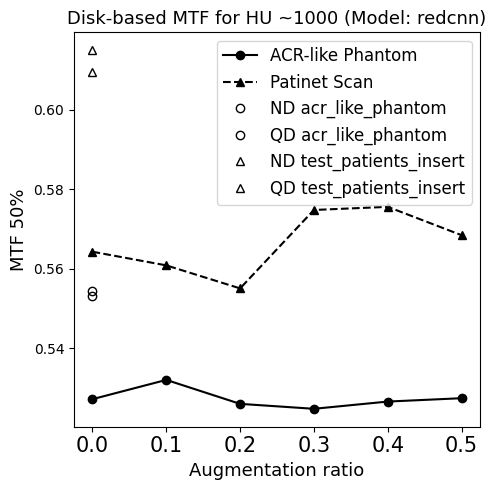

In [3]:
from diskmtf import ACRDisk, PatinetDisk

MODELS=['cnn3', 'dncnn', 'redcnn', 'unet']
MODELS=('redcnn' 'unet')

# _________________________________________________________________________
AUGMENTATION_DATA='acr_like_phantom'
#AUGMENTATION_DATA='catphan_like_phantom'
#AUGMENTATION_DATA='customize_phantom'
# _________________________________________________________________________

# _________________PLOT PARAM______________________________________________
fig, ax = plt.subplots(figsize=(5,5))
x = np.array([0, 1, 2, 3, 4, 5])
# _________________________________________________________________________

TEST_DATA = ['acr_like_phantom', 'test_patients_insert']

model = 'redcnn'
for i, test_type in enumerate (TEST_DATA):
    marker_style = 'o' if i==0 else '^'
    
    if test_type=='acr_like_phantom':
        filename='I0_0018000_*noisy_disk.raw'
        mtf_mean, mtf_std = get_all_disk_mtfs(ACRDisk, test_type, AUGMENTATION_DATA, model, filename, hu=1955, threshold=0.5)
        plt.plot(x, mtf_mean, marker=marker_style, linestyle='-', color='black', label= 'ACR-like Phantom')
        
        filename='I0_0072000_*noisy_disk.raw'
        mtf_mean, mtf_std = get_gt_disk_mtfs(ACRDisk, test_type, filename, hu=1955, threshold=0.5)
        plt.errorbar(x[0], mtf_mean, yerr=None, marker=marker_style, markerfacecolor='none', linestyle='', color='black', label='ND '+test_type)  

        filename='I0_0018000_*noisy_disk.raw'
        mtf_mean, mtf_std = get_gt_disk_mtfs(ACRDisk, test_type, filename, hu=1955, threshold=0.5)
        plt.errorbar(x[0], mtf_mean, yerr=None, marker=marker_style, markerfacecolor='none', linestyle='', color='black', label='QD '+test_type)  


    if test_type=='test_patients_insert':
        filename='I0_0200000__disk_r12_isim_*_noisy.raw'
        mtf_mean, mtf_std = get_all_disk_mtfs(PatinetDisk, test_type, AUGMENTATION_DATA, model, filename, hu=1955, threshold=0.5)
        plt.plot(x, mtf_mean, marker=marker_style, linestyle='--', color='black', label= 'Patinet Scan')

        
        filename='I0_0800000__disk_r12_isim_*_noisy.raw'
        mtf_mean, mtf_std = get_gt_disk_mtfs(PatinetDisk, test_type, filename, hu=1955, threshold=0.5)
        plt.errorbar(x[0], mtf_mean, yerr=None, marker=marker_style, markerfacecolor='none', linestyle='', color='black', label='ND '+test_type)  

        filename='I0_0200000__disk_r12_isim_*_noisy.raw'
        mtf_mean, mtf_std = get_gt_disk_mtfs(PatinetDisk, test_type, filename, hu=1955, threshold=0.5)
        plt.errorbar(x[0], mtf_mean, yerr=None, marker=marker_style, markerfacecolor='none', linestyle='', color='black', label='QD '+test_type)  


plt.xticks(x, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=15)       
plt.xlabel('Augmentation ratio', fontsize=13) 
plt.ylabel('MTF '+ str(int(0.5*100)) +'%', fontsize=13) 
plt.legend(fontsize=12)
plt.title("Disk-based MTF for HU ~1000"+" (Model: "+model+")",  position=(0.5, 1.1), ha='center', fontsize=13)
fig.tight_layout()


### LP-MTF

In [3]:
import numpy as np
import glob
import random

def get_file_paths(base_path, test_data, augment_data, model, filename, ratio):
    if ratio == '0.0':
        return glob.glob(f"{base_path}/{test_data}/{model}_ratio_{ratio}/denoised_{filename}")
    else:
        return glob.glob(f"{base_path}/{test_data}/augmented_with_{augment_data}/{model}_ratio_{ratio}/denoised_{filename}")


# Line-pair
def calculate_lp_mtfs(ObjClass, file_paths, threshold=0.5):
    if not file_paths:
        print(f"No files found at {file_paths}")
        return 0, 0
    
    # Calculate MTFs
    mtfs = [ObjClass(file).get_frequency_at(threshold) for file in file_paths]
    return np.mean(mtfs), np.std(mtfs)

def get_all_lp_mtfs(ObjClass, test_data, augment_data, model, filename, base_path, hu=1955, threshold=0.5):
    ratios = ['0.0', '0.1', '0.2', '0.3', '0.4', '0.5']
    mtf_means = []
    mtf_stds = []
    
    for r in ratios:
        file_paths = get_file_paths(base_path, test_data, augment_data, model, filename, r)
        if len(file_paths)==0:print(base_path, test_data, augment_data, model, filename, r)
        mean, std = calculate_lp_mtfs(ObjClass, file_paths, threshold)
        mtf_means.append(mean)
        mtf_stds.append(std)
    
    return mtf_means, mtf_stds

def get_gt_lp_mtfs(ObjClass, test_data, filename, base_path, hu=1955, threshold=0.5):
    
    file_path = f"{base_path}/{test_data}/{filename}"
    
    file_paths = glob.glob(file_path)
    if len(file_paths)==0:print(file_path)
    return calculate_lp_mtfs(ObjClass, file_paths, threshold)


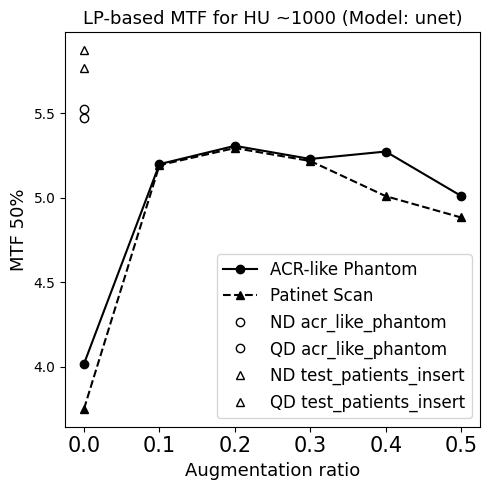

In [7]:
from lpmtf import ACRLinePair, PatientLinePair

MODELS=['cnn3', 'dncnn', 'redcnn', 'unet']
MODELS=('redcnn' 'unet')

# _________________________________________________________________________
AUGMENTATION_DATA='acr_like_phantom'
#AUGMENTATION_DATA='catphan_like_phantom'
#AUGMENTATION_DATA='customize_phantom'
# _________________________________________________________________________
BASE_PATH = '/gpfs_projects/md.selim/repo/CTBenchAugmentation/denoised/test_dataset'
BASE_PATH_GT = '/gpfs_projects/md.selim/repo/CTBenchAugmentation/datasets/test'

# _________________PLOT PARAM______________________________________________
fig, ax = plt.subplots(figsize=(5,5))
x = np.array([0, 1, 2, 3, 4, 5])
# _________________________________________________________________________

TEST_DATA = ['acr_like_phantom', 'test_patients_insert']

model = 'unet'
for i, test_type in enumerate (TEST_DATA):
    marker_style = 'o' if i==0 else '^'
    
    if test_type=='acr_like_phantom': 
        filename='I0_0018000_lp_1000_*noisy.raw' 
        mtf_mean, mtf_std = get_all_lp_mtfs(ACRLinePair, test_type, AUGMENTATION_DATA, model, filename, BASE_PATH, hu=1955, threshold=0.5)
        plt.plot(x, mtf_mean, marker=marker_style, linestyle='-', color='black', label= 'ACR-like Phantom')
        
        filename='I0_0072000_lp_1000_*noisy.raw'
        mtf_mean, mtf_std = get_gt_lp_mtfs(ACRLinePair, test_type, filename, BASE_PATH_GT, hu=1955, threshold=0.5)
        plt.errorbar(x[0], mtf_mean, yerr=None, marker=marker_style, markerfacecolor='none', linestyle='', color='black', label='ND '+test_type)  

        filename='I0_0018000_lp_1000_*noisy.raw'
        mtf_mean, mtf_std = get_gt_lp_mtfs(ACRLinePair, test_type, filename, BASE_PATH_GT, hu=1955, threshold=0.5)
        plt.errorbar(x[0], mtf_mean, yerr=None, marker=marker_style, markerfacecolor='none', linestyle='', color='black', label='QD '+test_type)  


    if test_type=='test_patients_insert':
        filename='I0_0200000__lp_hu_1000_Han2_05_0*_lp_2_3_noisy.raw'
        mtf_mean, mtf_std = get_all_lp_mtfs(PatientLinePair, test_type, AUGMENTATION_DATA, model, filename,BASE_PATH, hu=1955, threshold=0.5)
        plt.plot(x, mtf_mean, marker=marker_style, linestyle='--', color='black', label= 'Patinet Scan')

        
        filename='I0_0800000__lp_hu_1000_Han2_05_0*_lp_2_3_noisy.raw'
        mtf_mean, mtf_std = get_gt_lp_mtfs(PatientLinePair, test_type, filename, BASE_PATH_GT, hu=1955, threshold=0.5)
        plt.errorbar(x[0], mtf_mean, yerr=None, marker=marker_style, markerfacecolor='none', linestyle='', color='black', label='ND '+test_type)  

        filename='I0_0200000__lp_hu_1000_Han2_05_0*_lp_2_3_noisy.raw'
        mtf_mean, mtf_std = get_gt_lp_mtfs(PatientLinePair, test_type, filename, BASE_PATH_GT, hu=1955, threshold=0.5)
        plt.errorbar(x[0], mtf_mean, yerr=None, marker=marker_style, markerfacecolor='none', linestyle='', color='black', label='QD '+test_type)  


plt.xticks(x, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=15)       
plt.xlabel('Augmentation ratio', fontsize=13) 
plt.ylabel('MTF '+ str(int(0.5*100)) +'%', fontsize=13) 
plt.legend(fontsize=12)
plt.title("LP-based MTF for HU ~1000"+" (Model: "+model+")",  position=(0.5, 1.1), ha='center', fontsize=13)
fig.tight_layout()


In [3]:
file_path = './patient_and_digital_phantom_v3_sharpness.csv'
df = pd.read_csv(file_path)

model = 'cnn3'
roi='roi-1'

x = np.array([0, 1, 2, 3, 4, 5])

fig, ax = plt.subplots(figsize=(5,5))

for i, test_type in enumerate (['acr_sim', 'patinet']):
    marker_style = 'o' if i==0 else '^'
    
    filtered_df = df[(df['subject'] == test_type) & (df['roi'] == 'roi-1') & (df['model']== 'nd')]
    plt.errorbar(x[0], filtered_df['results'].to_list(), yerr=None, marker=marker_style, markerfacecolor='none', linestyle='', color='black', label='ND '+test_type)  

    filtered_df = df[(df['subject'] == test_type) & (df['roi'] == 'roi-1') & (df['model']== 'qd')]
    plt.errorbar(x[0], filtered_df['results'].to_list(), yerr=None, marker=marker_style, linestyle='', color='black', label='QD '+test_type)  

filtered_df = df[(df['subject'] == 'acr_sim') & (df['roi'] == 'roi-1') & (df['model']== model)]
plt.plot(x, filtered_df['results'].to_list(), marker=marker_style, linestyle='-', color='black', label= 'ACR-like Phantom')

filtered_df = df[(df['subject'] == 'patinet') & (df['roi'] == 'roi-1') & (df['model']== model)]
plt.plot(x, filtered_df['results'].to_list(), marker=marker_style, linestyle='--', color='black', label= 'Patinet Scan')
      
plt.xticks(x, [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=15)       
plt.xlabel('Augmentation ratio', fontsize=13) 
plt.ylabel('MTF '+ str(int(0.5*100)) +'%', fontsize=13) 
plt.legend(fontsize=12)
plt.title("Disk-based MTF for HU ~1000"+" (Model: "+model+")",  position=(0.5, 1.1), ha='center', fontsize=13)
fig.tight_layout()


FileNotFoundError: [Errno 2] No such file or directory: './patient_and_digital_phantom_v3_sharpness.csv'

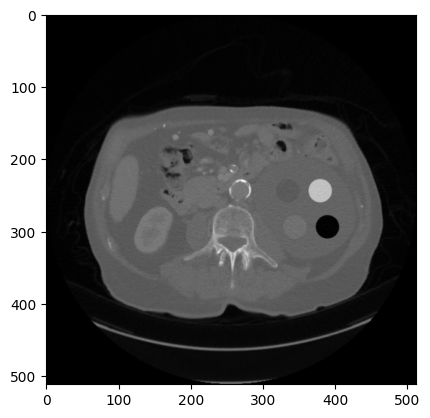

In [25]:
im_path = '/gpfs_projects/md.selim/repo/CTBenchAugmentation/datasets/test/test_patients_insert/I0_0800000__disk_r12_isim_008_noisy.raw'


try:
    with open(im_path, 'rb') as f:
        img = np.fromfile(f, dtype=np.int16).reshape((512, 512)).T
except FileNotFoundError:
    print(f"Cannot open file: {file_path}")

plt.imshow(img, cmap='gray')